In [123]:
import random

import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

In [105]:
ds = load_dataset("keremberke/pokemon-classification", "full")
ds

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 4869
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1390
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 732
    })
})

In [106]:
train_data = ds["train"].map(remove_columns=["image_file_path"], batched=True)
test_data = ds["test"].map(remove_columns=["image_file_path"], batched=True)
val_data = ds["validation"].map(remove_columns=["image_file_path"], batched=True)

train_data

Dataset({
    features: ['image', 'labels'],
    num_rows: 4869
})

In [107]:
def plot_image_size(data):
    width_size = {}

    height_size = {}

    for i in range(len(data)):
        img = data[i]["image"]
        if img.size[0] not in height_size:
            height_size[img.size[0]] = 1
        else:
            height_size[img.size[0]] += 1

        if img.size[1] not in width_size:
            width_size[img.size[1]] = 1
        else:
            width_size[img.size[1]] += 1

    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    ax[0].bar(width_size.keys(), width_size.values())
    ax[0].set_title("Width distribution")
    ax[0].set_xlabel("Width")
    ax[0].set_ylabel("Count")

    ax[1].bar(height_size.keys(), height_size.values())
    ax[1].set_title("Height distribution")
    ax[1].set_xlabel("Height")
    ax[1].set_ylabel("Count")


(None, None, None)

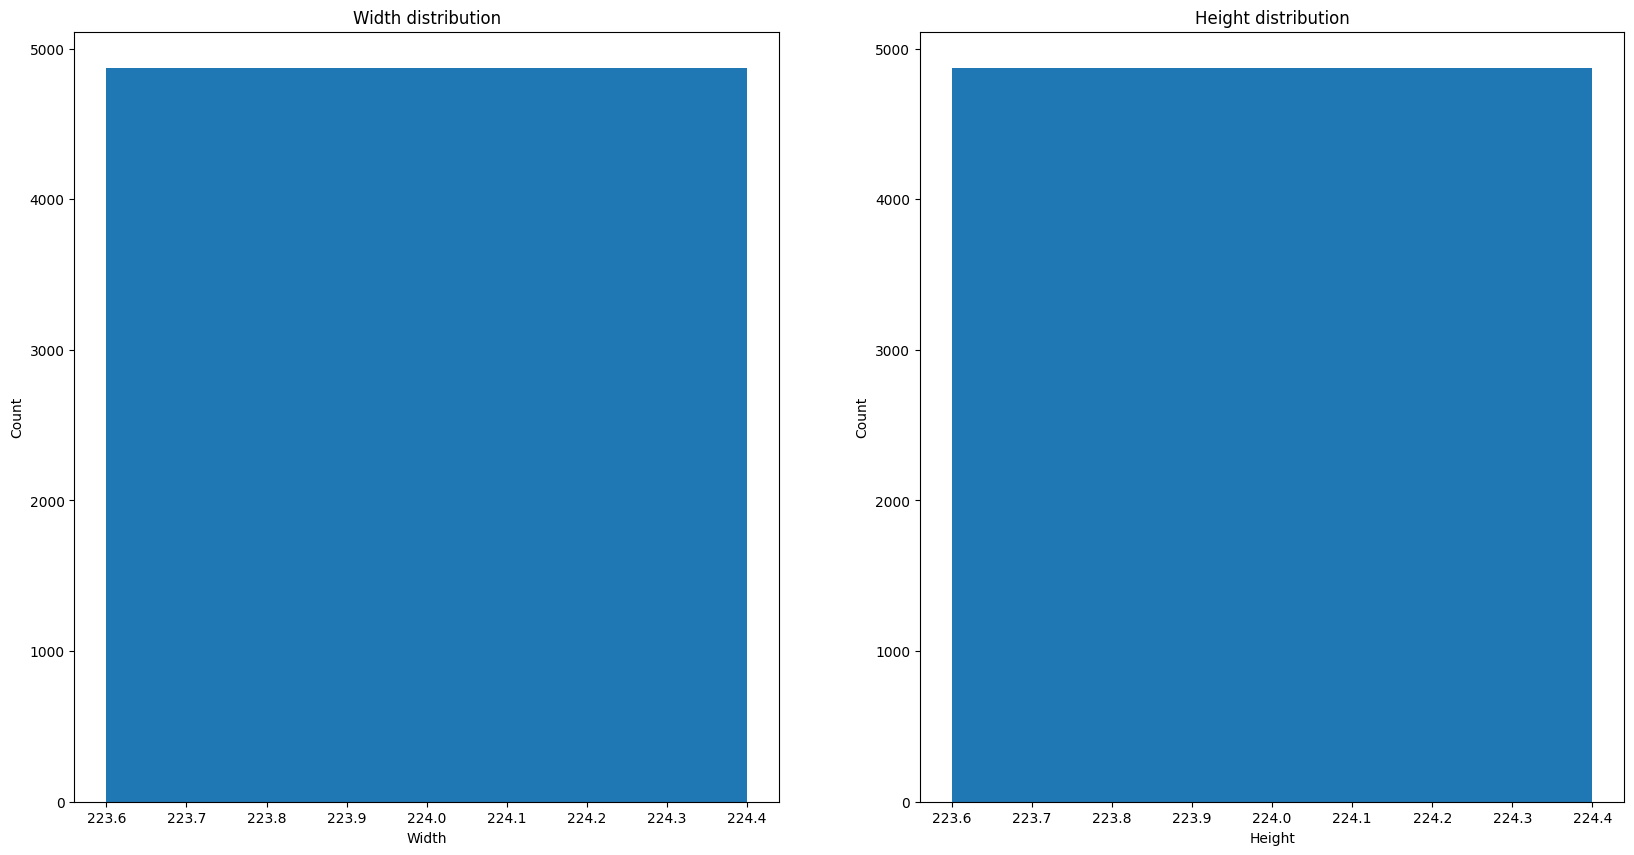

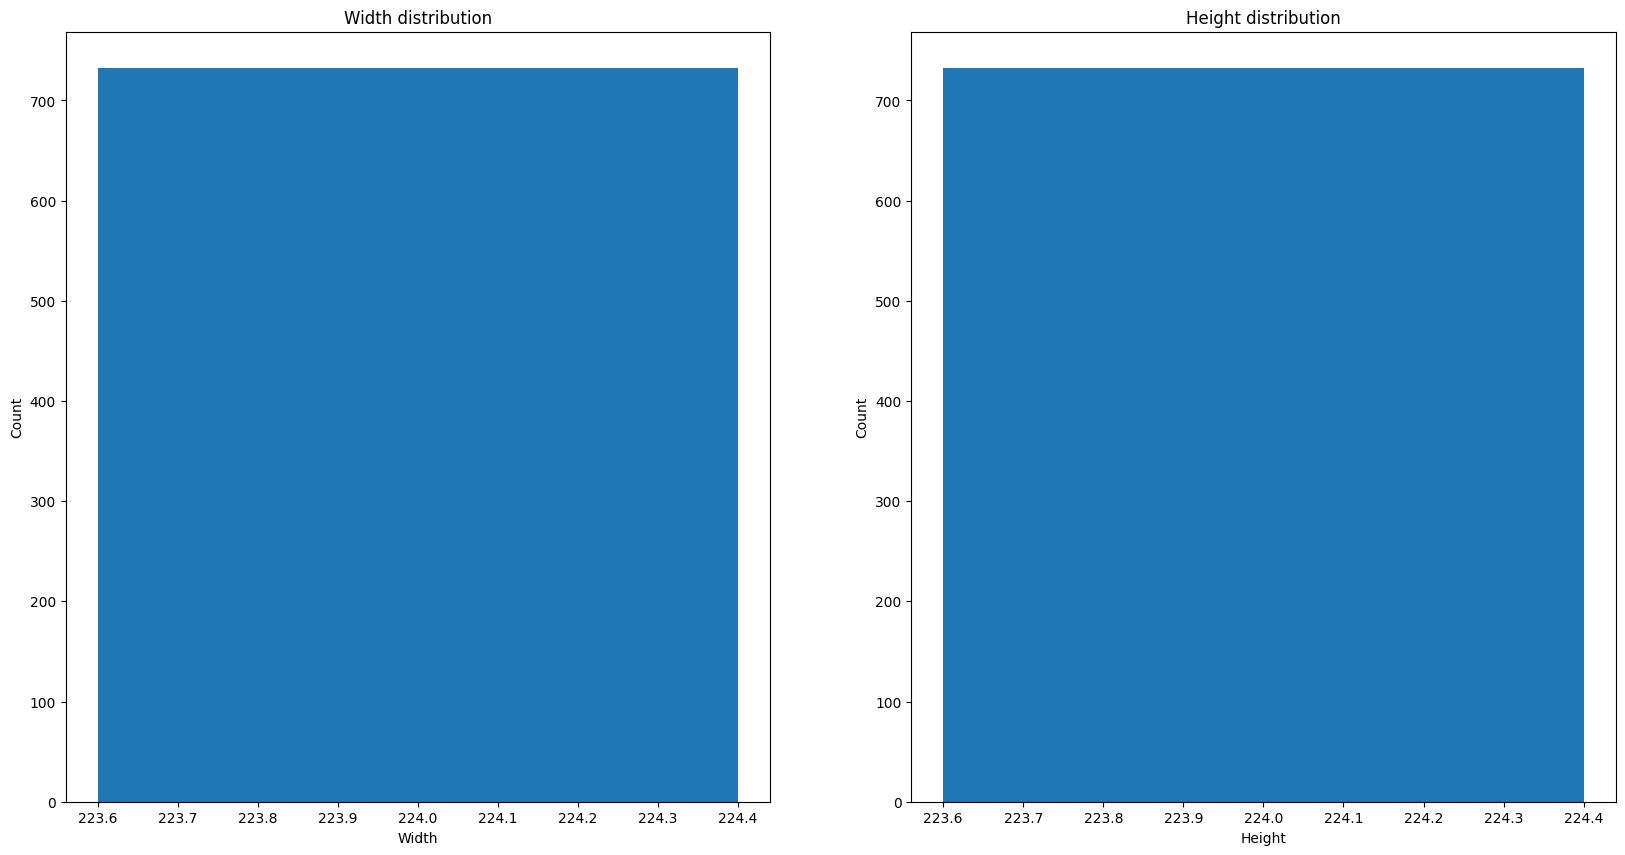

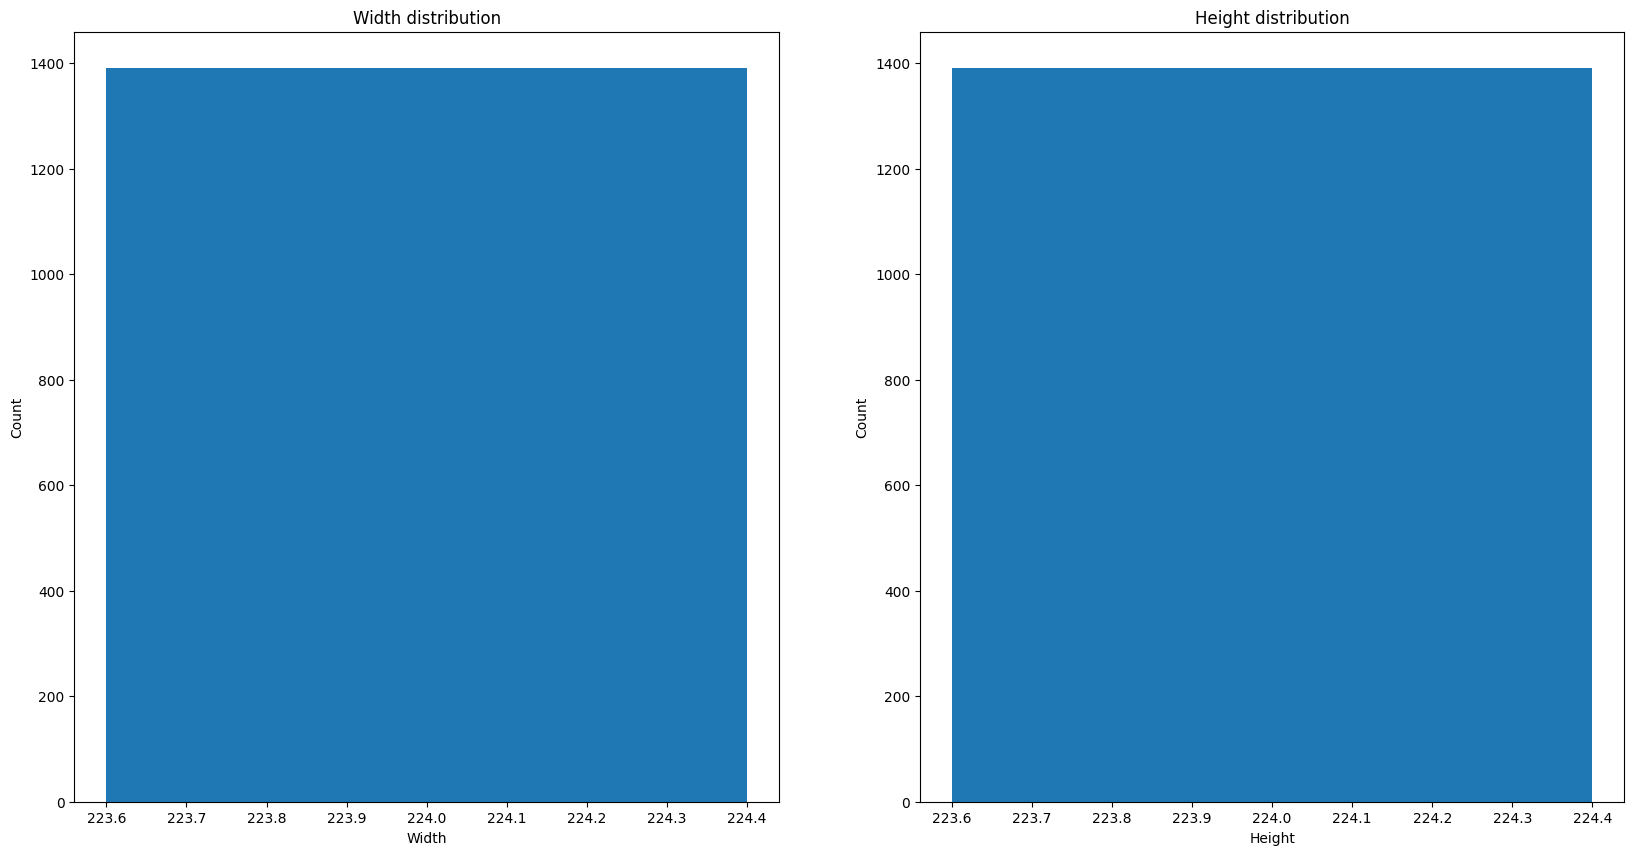

In [108]:
plot_image_size(train_data), plot_image_size(test_data), plot_image_size(val_data)

In [109]:
num_class = len(ds["train"].features["labels"].names)
num_class

150

In [110]:
from torchvision.transforms import Compose, RandomPerspective, ToTensor, RandomRotation, Normalize
composer = Compose(
    [
        RandomRotation(degrees=(0, 180)),
        RandomPerspective(distortion_scale=0.5, p=0.5),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

def transforms(data):
    data["image"] = [composer(image.convert("RGB")) for image in data["image"]]
    return data

In [111]:
import random
import matplotlib.pyplot as plt
import torchvision.transforms as T

def plot_original_and_transformed(dataset, transform, num_samples=6):
    num_rows = -(-num_samples // 2)  # Ceiling division for rows with 2 comparisons each
    fig, axes = plt.subplots(num_rows, 4, figsize=(12, num_rows * 4))
    fig.suptitle("Original and Transformed Comparisons", fontsize=16)
    
    indices = random.sample(range(len(dataset)), num_samples)
    
    for i, idx in enumerate(indices):
        row = i // 2
        col = (i % 2) * 2 # Alternate between columns for original and transformed
        
        original_image = dataset[idx]["image"]
        transformed_image = transform({"image": [original_image]})["image"][0]
        
        # Convert tensors to PIL images for visualization
        to_pil = T.ToPILImage()
        original_pil = to_pil(T.ToTensor()(original_image))
        transformed_pil = to_pil(transformed_image)
        
        # Plot original
        axes[row, col].imshow(original_pil)
        axes[row, col].set_title("Original")
        axes[row, col].axis("off")
        
        # Plot transformed
        axes[row, col + 1].imshow(transformed_pil)
        axes[row, col + 1].set_title("Transformed")
        axes[row, col + 1].axis("off")
    
    # Hide unused subplots
    for i in range(num_samples, num_rows * 2):
        row = i // 2
        col = (i % 2) * 2
        axes[row, col].axis("off")
        axes[row, col + 1].axis("off")
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


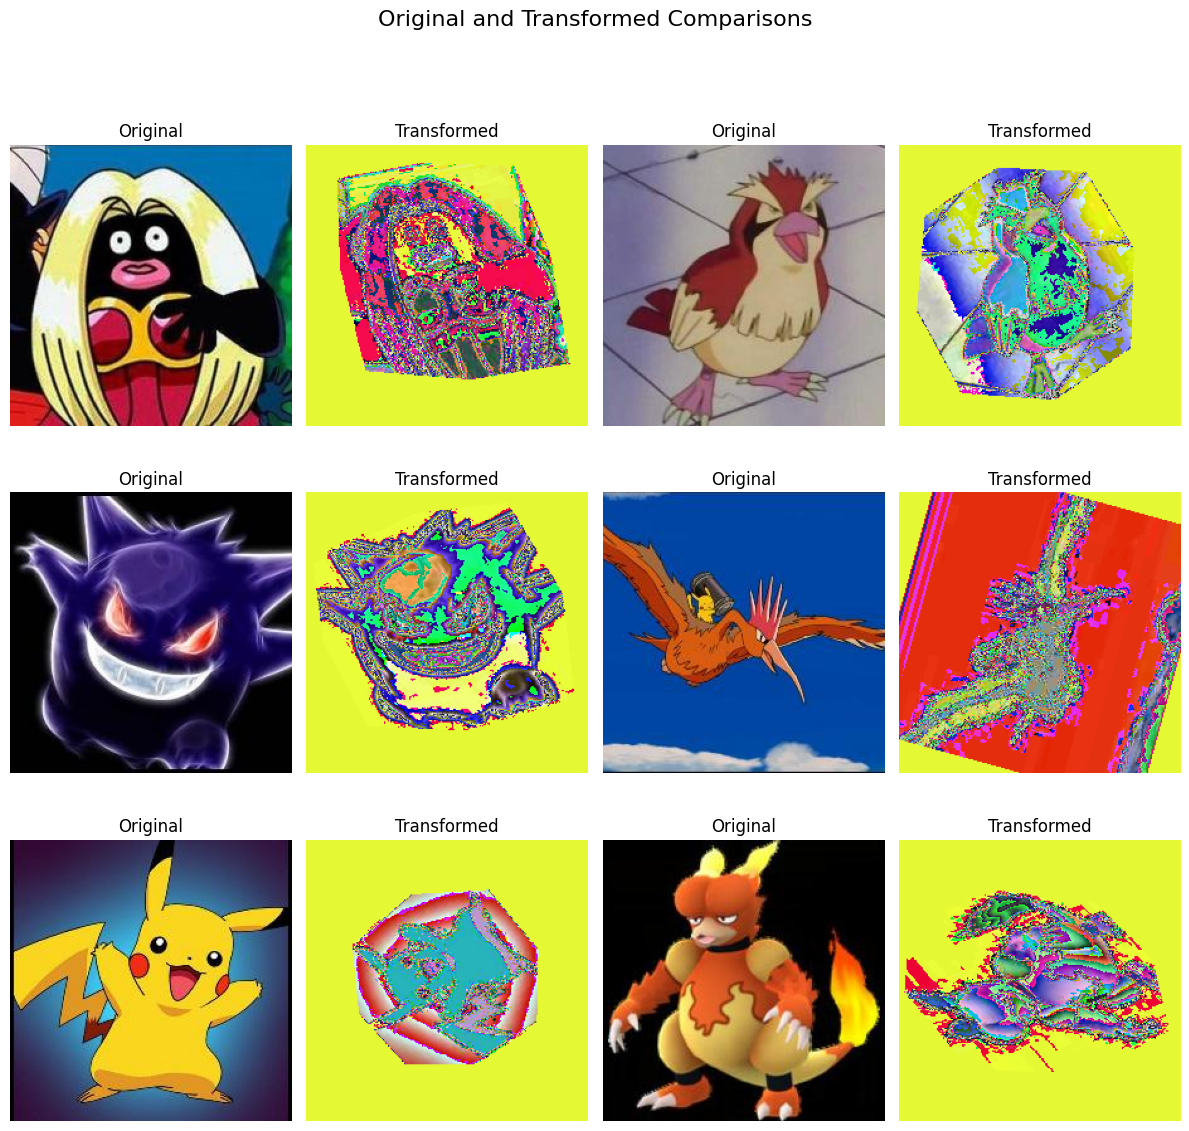

In [112]:
plot_original_and_transformed(train_data, transforms)

In [113]:
train_data.set_transform(transforms)
val_data.set_transform(transforms)

In [119]:
class PokemonDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        return item["image"], item["labels"]
    
train_dataset = PokemonDataset(train_data)
val_dataset = PokemonDataset(val_data)

In [120]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)

In [145]:
class PokemonModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.convolutions = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.convolutions(x)
        print(f"Shape after conv: {x.shape}")
        x = x.view(x.size(0), -1)
        print(f"Shape after flat: {x.shape}")
        x = self.classifier(x)
        return x

In [146]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PokemonModel(num_class).to(device)
optimizer = Adam(model.parameters(), lr=0.001)
criterion = CrossEntropyLoss()

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

In [ ]:
train_one_epoch(model, train_dataloader, criterion, optimizer, device)

Shape after conv: torch.Size([32, 64, 28, 28])
Shape after flat: torch.Size([32, 50176])
Shape after conv: torch.Size([32, 64, 28, 28])
Shape after flat: torch.Size([32, 50176])
Shape after conv: torch.Size([32, 64, 28, 28])
Shape after flat: torch.Size([32, 50176])
Shape after conv: torch.Size([32, 64, 28, 28])
Shape after flat: torch.Size([32, 50176])
Shape after conv: torch.Size([32, 64, 28, 28])
Shape after flat: torch.Size([32, 50176])
Shape after conv: torch.Size([32, 64, 28, 28])
Shape after flat: torch.Size([32, 50176])
Shape after conv: torch.Size([32, 64, 28, 28])
Shape after flat: torch.Size([32, 50176])
Shape after conv: torch.Size([32, 64, 28, 28])
Shape after flat: torch.Size([32, 50176])
Shape after conv: torch.Size([32, 64, 28, 28])
Shape after flat: torch.Size([32, 50176])
Shape after conv: torch.Size([32, 64, 28, 28])
Shape after flat: torch.Size([32, 50176])
Shape after conv: torch.Size([32, 64, 28, 28])
Shape after flat: torch.Size([32, 50176])
Shape after conv: tor